In [ ]:
# ! pip install transformers[torch]
# ! pip install datasets
# ! pip install optuna
# ! pip3 install -q -U bitsandbytes==0.42.0
# ! pip3 install -q -U peft==0.8.2
# ! pip3 install -q -U trl==0.7.10

In [ ]:
# Import the required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import sklearn
from transformers import BitsAndBytesConfig,AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction, EarlyStoppingCallback
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
import bitsandbytes as bnb
import optuna
from optuna.samplers import TPESampler
from datasets import load_dataset, load_metric
from datasets import Dataset
import time

import warnings
# Suppress the SettingWithCopyWarning
warnings.filterwarnings("ignore")

/home/nicola/anaconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Recognizing Textual Entailment (RTE)

The RTE task is a natural language processing (NLP) task that involves determining whether one piece of text logically entails another.<br>
In our case, we will handle pairs of sentences indicated by the features text1 and text2 to verify if there is an **implication** between the first and the second. <br> Since the RTE task is supervised, the 'label_text' feature provides us with the label assigned for such pairs of sentences. Finally, 'idx' merely indicates the row index of the dataset.

In [ ]:
# Load the RTE dataset
dataset = load_dataset("SetFit/rte")
print(dataset)

Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text'],
        num_rows: 277
    })
    test: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text'],
        num_rows: 3000
    })
})


# Dataset labels
* **entailment** means that one sentence logically follows from another.
* **not entailment** means that there's no logical connection between two sentences.

Text(0.5, 1.0, 'SetFit/rte labels')

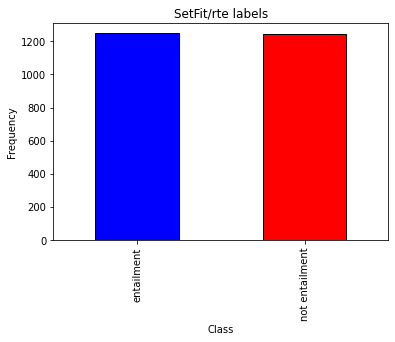

In [ ]:
labels = pd.Series(dataset["train"]["label_text"])
labels.value_counts().plot(kind = 'bar', color = ['blue','red'],edgecolor = "black")

plt.xlabel('Class')
plt.ylabel('Frequency')

plt.title("SetFit/rte labels")

# Dataset sample
This is how a sample of SetFit/rte is organized
* Label = 0, entailment.
* Label = 1, not entailment.

In [ ]:
print("Entailment : "+ dataset["train"]["text1"][0])
print("\n")
print("Contradiction : "+ dataset["train"]["text2"][0])
print("\n")
print("Label : ",dataset["train"]["label"][0])
print("\n")
print("Text Label : "+ dataset["train"]["label_text"][0])

Entailment : No Weapons of Mass Destruction Found in Iraq Yet.


Contradiction : Weapons of Mass Destruction Found in Iraq.


Label :  1


Text Label : not entailment


In [ ]:
for s in ["text1", "text2"] :
  max_sentence_length = len(dataset["train"][s][0])
  for i in range(1,len(dataset["train"])) :
    if max_sentence_length < len(dataset["train"][s][i]) :
      max_sentence_length = len(dataset["train"][s][i])
  print(s + " training sentece with max length : ", max_sentence_length)

text1 training sentece with max length :  1392
text2 training sentece with max length :  230


# Loading Model


**DeBERTa-v3-base** is a version of the DeBERTa (Decoding-enhanced BERT with disentangled attention) model, which is a transformer-based language model developed by Microsoft.

* **Disentangled Attention**: where each word is represented using two vectors that encode its content and position, respectively, and the attention weights among words are computed using disentangled matrices on their contents and relative positions.

* **Enhanced Mask Decoder**:  is used to replace the output softmax layer to predict the masked tokens for model pretraining. DeBERTa introduces enhancements to the decoding process, allowing the model to generate more coherent and contextually relevant outputs during tasks such as text generation and language modeling.

* **Robust Performance**: DeBERTa has demonstrated strong performance on various natural language processing tasks, including text classification, question answering, and language understanding tasks.

* https://huggingface.co/docs/transformers/model_doc/deberta-v2

In [ ]:
# Load the DeBERTa-v3-base tokenizer and model
model_name = "microsoft/deberta-v3-base"
#model_name = "bert-base-cased"
deberta_tokenizer = AutoTokenizer.from_pretrained(model_name)
deberta_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Info about the Tokenizer

DebertaV2TokenizerFast is based on SentencePiece, which is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing.

* https://github.com/google/sentencepiece

In [ ]:
print(str(deberta_tokenizer).partition('\n')[0:2])

("DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-base', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={", '\n')


# Tokenizzation

In this phase, we would apply the tokenizer to each example belonging to the dataset SetFit/rte. As a result, the dataset will have additional features:


1.  **input_ids**, convert the tokens into indices (IDs) associated with the DeBERTa vocabulary.

2.   **token_type_ids**, identifies the belonging to a sentence in case there are two sentences in the same sample, <br> zeros belong to the first sentence and ones belong to the second sentence.

3. **attention_mask**, is a binary tensor indicating the position of the padded indices so that the model does not attend to them. <br> (For the BertTokenizer, 1 indicates a value that should be attended to, while 0 indicates a padded value, look at this link for additional information :https://huggingface.co/docs/transformers/glossary#attention-mask )

In [ ]:
# Disabling parallelism to avoid deadlocks
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Tokenize the dataset
def tokenize_function(examples, tokenizer):
    return tokenizer(examples["text1"], examples["text2"], truncation = True, padding = 'max_length', max_length=256)

In [ ]:
deberta_tokenized_data = dataset.map(lambda x: tokenize_function(x, deberta_tokenizer), batched=True) # map applies the tokenize_function to all the rows of the dataset.
print(deberta_tokenized_data)
# The new fields: input_ids, convert the tokens into indices (IDs) associated with the DeBERTa vocabulary.
#                 token_type_ids, identifies the belonging to a sentence in case there are two sentences in the same sample
#                 attention_mask, indicates to the model which tokens it should pay attention to during training

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 277
    })
    test: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
})


# Example of tokenized sentence
For greater clarity, we will analyze how the DebertaV2TokenizerFast tokenizer  works <br> by extracting a training example from the Set/rte dataset, consisting of text1, text2, and label.<br>
Notice that
* Special tokens are the same as the primary version of the model BERT

* Attention mask is zero only for padding

* token_type_ids is set to one only for the sentence belonging to the feature text2.

In [ ]:
print("1) Example of first sentence  :\n ", deberta_tokenized_data["train"]['text1'][2])
print("\n")
print("2) Example of second sentence  :\n ", deberta_tokenized_data["train"]['text2'][2])
print("\n")
print("3) Example of RTE label :\n ", deberta_tokenized_data["train"]['label_text'][2])

1) Example of first sentence  :
  Herceptin was already approved to treat the sickest breast cancer patients, and the company said, Monday, it will discuss with federal regulators the possibility of prescribing the drug for more breast cancer patients.


2) Example of second sentence  :
  Herceptin can be used to treat breast cancer.


3) Example of RTE label :
  entailment


In [ ]:
# Accessing the tokens ID of the first sentence in the input_ids field.
first_example_tokens = deberta_tokenized_data["train"]["input_ids"][2]

# Convert tokens ID to tokens using the tokenizer
tokens = [deberta_tokenizer.decode(token_id, skip_special_tokens=False) for token_id in first_example_tokens]

print(tokens)


['[CLS]', 'Her', 'cept', 'in', 'was', 'already', 'approved', 'to', 'treat', 'the', 'sick', 'est', 'breast', 'cancer', 'patients', ',', 'and', 'the', 'company', 'said', ',', 'Monday', ',', 'it', 'will', 'discuss', 'with', 'federal', 'regulators', 'the', 'possibility', 'of', 'prescribing', 'the', 'drug', 'for', 'more', 'breast', 'cancer', 'patients', '.', '[SEP]', 'Her', 'cept', 'in', 'can', 'be', 'used', 'to', 'treat', 'breast', 'cancer', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

In [ ]:
a = pd.Series(deberta_tokenized_data["train"]["attention_mask"][2])
b = pd.Series(deberta_tokenized_data["train"]["input_ids"][2])
c = pd.Series(deberta_tokenized_data["train"]["token_type_ids"][2])

df = pd.DataFrame({'tokens':tokens,'input_ids': b, 'attention_mask': a, 'token_type_ids':c})
# Example of single sentence output after tokenization
print(df[:60])

         tokens  input_ids  attention_mask  token_type_ids
0         [CLS]          1               1               0
1           Her       1620               1               0
2          cept      29813               1               0
3            in        547               1               0
4           was        284               1               0
5       already        637               1               0
6      approved       2664               1               0
7            to        264               1               0
8         treat       2435               1               0
9           the        262               1               0
10         sick       3808               1               0
11          est       5260               1               0
12       breast       4311               1               0
13       cancer       1771               1               0
14     patients       1171               1               0
15            ,        261               1              

# Define common metrics

To evaluate the model, we could limit ourselves to assessing accuracy since we are dealing with a balanced dataset.<br> However, for a more comprehensive evaluation, we also include precision, recall, and f1_score.

In [ ]:
def compute_metrics(eval_prediction):
    predictions, labels = eval_prediction
    predictions = torch.from_numpy(predictions)  # Convert predictions to PyTorch tensor
    labels = torch.from_numpy(labels)  # Convert labels to PyTorch tensor

    predictions = torch.argmax(predictions, dim=1).cpu().numpy()  # Convert to NumPy array
    labels = labels.cpu().numpy()  # Convert to NumPy array

    accuracy = sklearn.metrics.accuracy_score(labels, predictions)
    precision = sklearn.metrics.precision_score(labels, predictions, average='binary')
    recall = sklearn.metrics.recall_score(labels, predictions, average='binary')
    f1 = sklearn.metrics.f1_score(labels, predictions, average='binary')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Checking if GPU is available

In [ ]:
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print(f"Training on GPU: {torch.cuda.get_device_name(device)}")
else:
    print("No GPU available, training on CPU.")


Training on GPU: NVIDIA GeForce RTX 3060


# Randomized Search

* In this section, we want to create a 'study' using the Optuna library which is useful for hyperparameter search. <br> First, we need to define a function to optimize. In our case, during the fine-tuning of the model we have chosen, we want it to perform well on the validation set. Therefore, we will maximize the accuracy on the validation set.

* The choice of hyperparameters is crucial for achieving good learning results and also for avoiding high computational costs. <br>In particular, a batch size of 8 speeds up learning by using 8 examples to evaluate one gradient descent step. <br> Setting evaluation steps to 100 increases the frequency of updating the model's performance on the validation set. <br> A learning rate between 10^(-6) and 10^(-4) should allow us to reach convergence a bit more slowly but with greater certainty. <br> Weight decay between 10^(-5) and 10^(-3) should significantly reduce the size of the weight matrix, acting as a regularizer. Squared L2 norm should aid the fine-tuning process by lowering accuracy on the training set and reducing overfitting.

* The hyperparameter selection is random only for the learning rate and weight decay, as they can take values of vastly different scales, and it's not straightforward to determine the best possible value for optimal performance. The choice of such a value follows a log-uniform distribution.
(https://en.wikipedia.org/wiki/Reciprocal_distribution)

* Additional information about how optuna works :
* https://medium.com/carbon-consulting/transformer-models-hyperparameter-optimization-with-the-optuna-299e185044a8
* https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html
* https://optuna.readthedocs.io/en/stable/faq.html#what-happens-when-i-dynamically-alter-a-search-space

In [ ]:
def optuna_hp_space(trial):
  return {
        "learning_rate": trial.suggest_loguniform("learning_rate", low = 5e-6, high = 1e-4),
        #"num_train_epochs": trial.suggest_int("num_train_epochs", low = 2, high = 5),
        "weight_decay": trial.suggest_loguniform("weight_decay", 1e-5, 1e-3), # applying the norm L2^2, reduce weights dimension, reduce overfitting
    }

# trainer.hyperparameter_search(direction="maximize", hp_space = optuna_hp_space)

# Optimizing Hyperparameters with Optuna: From Experiments to Fine-Tuning

We define the hyperparameter grid as previously specified and define the objective function to optimize,<br> which is the accuracy on the validation set. Next, we will conduct several experiments (n_trials), <br>select the one that satisfies us the most in terms of performance, and then proceed to fine-tune it.

In [ ]:
def objective(trial):
  # Define hyperparameters to search over
  hparams = optuna_hp_space(trial)

  # Set up training arguments with current hyperparameters
  training_args = TrainingArguments(
      output_dir=f"./DeBERTa_rte_steps_100_batch_8/trial_{trial.number}",
      evaluation_strategy="steps", #The evaluation strategy to adopt during training, "epoch" or "steps": Evaluation is done (and logged) every eval_steps or epoch
      eval_steps= 100,# eval_steps is a parameter that specifies how often the model should evaluate its performance on the validation dataset during training, measured in terms of training steps
      per_device_train_batch_size =  8, # Define the batch size for training on each device (e.g., GPU).
      learning_rate = hparams["learning_rate"],
      weight_decay = hparams["weight_decay"],
      num_train_epochs =  10, # num_train_epochs is a parameter that specifies the number of epochs (complete passes through the entire training dataset) to train the model.
      logging_steps = 100,
      logging_dir = f"./DeBERTa_rte_steps_100_batch_8/trial_{trial.number}",
      overwrite_output_dir = True,
      disable_tqdm = False,  # Enable tqdm progress bars
  )
  # add callbacks to stop training if the maximization of the objective function gives bad result after "patience" epochs
  callbacks = [EarlyStoppingCallback(early_stopping_patience=7)]

  # Initialize the Trainer
  trainer = Trainer(
    model=deberta_model,
    args=training_args,
    train_dataset=deberta_tokenized_data["train"],
    eval_dataset=deberta_tokenized_data["validation"],
    compute_metrics=compute_metrics,
  )

  # Record the starting time
  # start_time = time.time()

  # Fine-tune the model with Cross-Entropy loss
  trainer.train()

  # Evaluate the model and return the validation metric
  eval_results = trainer.evaluate()

  return eval_results["eval_accuracy"]

# Results of DeBERTa Model Experiments

Considering both the trend of the loss and the accuracy on the validation set, <br> with a broader look at the problem, trial 0 is the one that satisfies us the most.


In [ ]:
# Perform hyperparameter search with Optuna
start_time = time.time()
study = optuna.create_study(study_name='hyper-parameter-search', direction="maximize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials = 5)
end_time = time.time()
study_time = end_time - start_time

# Gives the best validation accuracy value
print("study best value is : \n")
print(study.best_value)
print("\n\n")

# Gives the best hyperparameter values to get the best validation accuracy value
print("study best parameters are : \n")
print(study.best_params)
print("\n\n")

# Return info about best Trial such as start and end datetime, hyperparameters
print("study best trial is : \n")
print(study.best_trial)
print("\n\n")

# study time
print("time to complete study : ", study_time)
print("\n\n")

[I 2024-06-25 12:33:42,188] A new study created in memory with name: hyper-parameter-search


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.695800,0.682630,0.527076,0.000000,0.000000,0.000000
200,0.662600,0.551113,0.743682,0.750000,0.687023,0.717131
300,0.546400,0.508267,0.776173,0.855670,0.633588,0.728070
400,0.423100,0.529771,0.819495,0.864865,0.732824,0.793388
500,0.387900,0.458151,0.851986,0.835821,0.854962,0.845283
600,0.379000,0.506453,0.844765,0.838462,0.832061,0.835249
700,0.244700,0.712960,0.833935,0.897196,0.732824,0.806723
800,0.188000,0.747608,0.855596,0.864000,0.824427,0.843750
900,0.197600,0.952183,0.826715,0.860870,0.755725,0.804878
1000,0.167200,1.020486,0.830325,0.833333,0.801527,0.817121


[I 2024-06-25 12:55:07,099] Trial 0 finished with value: 0.8267148014440433 and parameters: {'learning_rate': 1.5355286838886852e-05, 'weight_decay': 0.0007969454818643932}. Best is trial 0 with value: 0.8267148014440433.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.247800,1.080141,0.794224,0.768116,0.809160,0.788104
200,0.240600,1.999705,0.722022,0.897059,0.465649,0.613065
300,0.199700,1.506592,0.761733,0.809524,0.648855,0.720339
400,0.176200,1.306150,0.815884,0.812500,0.793893,0.803089
500,0.204700,1.328071,0.779783,0.710843,0.900763,0.794613
600,0.155800,1.038432,0.805054,0.823529,0.748092,0.784000
700,0.148400,0.956365,0.815884,0.773973,0.862595,0.815884
800,0.159100,1.011042,0.815884,0.803030,0.809160,0.806084
900,0.145800,1.899058,0.736462,0.881579,0.511450,0.647343
1000,0.165700,1.294752,0.805054,0.834783,0.732824,0.780488


[I 2024-06-25 13:16:17,423] Trial 1 finished with value: 0.8050541516245487 and parameters: {'learning_rate': 4.4803926826840614e-05, 'weight_decay': 0.00015751320499779721}. Best is trial 0 with value: 0.8267148014440433.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.000000,2.691207,0.787004,0.833333,0.687023,0.753138
200,0.000000,2.662573,0.808664,0.842105,0.732824,0.783673
300,0.000000,2.762963,0.805054,0.834783,0.732824,0.780488
400,0.000000,3.067825,0.787004,0.833333,0.687023,0.753138
500,0.001800,2.771522,0.805054,0.751634,0.877863,0.809859
600,0.045100,2.200373,0.833935,0.834646,0.809160,0.821705
700,0.013300,2.137686,0.833935,0.840000,0.801527,0.820312
800,0.017700,2.206198,0.823105,0.836066,0.778626,0.806324
900,0.000000,2.157055,0.833935,0.834646,0.809160,0.821705
1000,0.013000,2.029636,0.826715,0.826772,0.801527,0.813953


[I 2024-06-25 13:36:22,720] Trial 2 finished with value: 0.8303249097472925 and parameters: {'learning_rate': 7.979118876474868e-06, 'weight_decay': 2.0511104188433963e-05}. Best is trial 2 with value: 0.8303249097472925.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.000000,2.693255,0.826715,0.848739,0.770992,0.808000
200,0.000000,2.920522,0.819495,0.846154,0.755725,0.798387
300,0.000000,2.968400,0.823105,0.841667,0.770992,0.804781
400,0.000000,3.087546,0.808664,0.800000,0.793893,0.796935
500,0.000000,3.138637,0.808664,0.800000,0.793893,0.796935
600,0.000000,3.282934,0.812274,0.831933,0.755725,0.792000
700,0.000000,3.305600,0.812274,0.831933,0.755725,0.792000
800,0.000000,3.323455,0.812274,0.831933,0.755725,0.792000
900,0.000000,3.340673,0.812274,0.831933,0.755725,0.792000
1000,0.000000,3.356057,0.812274,0.831933,0.755725,0.792000


[I 2024-06-25 13:55:49,649] Trial 3 finished with value: 0.8158844765342961 and parameters: {'learning_rate': 5.950295391592121e-06, 'weight_decay': 0.0005399484409787432}. Best is trial 2 with value: 0.8303249097472925.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.000000,3.622409,0.815884,0.833333,0.763359,0.796813
200,0.000000,3.715915,0.815884,0.833333,0.763359,0.796813
300,0.000000,3.776462,0.815884,0.833333,0.763359,0.796813
400,0.000000,3.821442,0.815884,0.833333,0.763359,0.796813
500,0.000000,3.857996,0.815884,0.833333,0.763359,0.796813
600,0.000000,3.889584,0.815884,0.833333,0.763359,0.796813
700,0.000000,3.916267,0.815884,0.833333,0.763359,0.796813
800,0.000000,3.938492,0.815884,0.833333,0.763359,0.796813
900,0.000000,3.957604,0.815884,0.833333,0.763359,0.796813
1000,0.000000,3.974280,0.815884,0.833333,0.763359,0.796813


[I 2024-06-25 14:15:15,088] Trial 4 finished with value: 0.8122743682310469 and parameters: {'learning_rate': 3.027182927734626e-05, 'weight_decay': 0.0002607024758370766}. Best is trial 2 with value: 0.8303249097472925.


study best value is : 

0.8303249097472925



study best parameters are : 

{'learning_rate': 7.979118876474868e-06, 'weight_decay': 2.0511104188433963e-05}



study best trial is : 

FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.8303249097472925], datetime_start=datetime.datetime(2024, 6, 25, 13, 16, 17, 423416), datetime_complete=datetime.datetime(2024, 6, 25, 13, 36, 22, 720679), params={'learning_rate': 7.979118876474868e-06, 'weight_decay': 2.0511104188433963e-05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0001, log=True, low=5e-06, step=None), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-05, step=None)}, trial_id=2, value=None)



time to complete study :  6092.901935338974





In [ ]:
# best accuracy found
study.best_trial.values[0]

0.8303249097472925

In [ ]:
# study with best validation accuracy
study.best_trial

FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.8303249097472925], datetime_start=datetime.datetime(2024, 6, 25, 13, 16, 17, 423416), datetime_complete=datetime.datetime(2024, 6, 25, 13, 36, 22, 720679), params={'learning_rate': 7.979118876474868e-06, 'weight_decay': 2.0511104188433963e-05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0001, log=True, low=5e-06, step=None), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-05, step=None)}, trial_id=2, value=None)

In [ ]:
# study with the lowest validation loss
study.trials[0]

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.8267148014440433], datetime_start=datetime.datetime(2024, 6, 25, 12, 33, 42, 189932), datetime_complete=datetime.datetime(2024, 6, 25, 12, 55, 7, 99450), params={'learning_rate': 1.5355286838886852e-05, 'weight_decay': 0.0007969454818643932}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0001, log=True, low=5e-06, step=None), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-05, step=None)}, trial_id=0, value=None)

In [ ]:
study.trials[0].params

{'learning_rate': 1.5355286838886852e-05,
 'weight_decay': 0.0007969454818643932}

In [ ]:
# copy study.trials[0] parameters in case of out_of_memory problem
params = {'learning_rate': 1.5355286838886852e-05,
 'weight_decay': 0.0007969454818643932}

# DeBERTa Inference on test set

We have selected a **small** subset of the test set to be able to compare the models on unseen data. <br>
To do this, we will ask Chat-GPT to provide **labels** on unseen data, <br> then we will compare the predictions between the various models before and after performing fine-tuning <br> (on the SetFit/rte dataset).

In [ ]:
# provides a subset of the test set fixed
def get_test_data (dataset):
  test_data = dataset["test"][200:220]
  test_dataset = Dataset.from_dict(test_data)
  test_dataset = test_dataset.remove_columns(['label', 'label_text'])
  return test_dataset

In [ ]:
test_dataset = get_test_data(deberta_tokenized_data)

In [ ]:
test_dataset['text1']

['Scientists have discovered that drinking tea protects against heart disease by improving the function of the artery walls.',
 "Most notably, the Women's Health Initiative recently found that postmenopausal women taking estrogen with progestin have an increased risk of breast cancer as well as heart attack, stroke, and blood clots.",
 'Although panic disorders and agoraphobia are widespread in the general population, almost half of those afflicted with these problems do not receive treatment for them.',
 'Restricted items are those items that are not acceptable for purchase using government appropriated funds. Some examples of items that the General Accounting Office (GAO) considers "restricted" include: food, live entertainment, and personal gifts including plaques.',
 "Folk art embodies different parts of the nation's indigenous culture, minority languages, and philosophy.",
 'Since August 1999 an increase of the seismic activity has marked the beginning of a seismic sequence which 

In [ ]:
test_dataset['text2']

['Tea protects from some diseases.',
 'Estrogen is used by postmenopausal women.',
 'Agoraphobia is a widespread disorder.',
 'A government purchases food.',
 'Indigenous folk art is preserved.',
 'There was an increase in seismic activity.',
 'There was an increase in seismic activity',
 'Shipwreck salvaging was attempted.',
 'The government took measures to reduce pollution.',
 'Soldiers have been trained using virtual reality.',
 'A shark attacked a human being.',
 'Tea protects from illness.',
 'Tea protects from some diseases.',
 'Agoraphobia is a widespread disorder.',
 'Cars exported by Japan decreased.',
 'An earthquake occurred in Hokkaido, Japan.',
 'An oil pipeline in Siberia was ruptured.',
 'An oil pipeline in Siberia was ruptured.',
 'A European synagogue was the target of an act of terrorism.',
 'The government took measures to protect the environment.']

# ChatGpt RTE predictions on test set

1. 'Scientists have discovered that drinking tea protects against heart disease by improving the function of the artery walls.' - 'Tea protects from some diseases.' → 0
2. "Most notably, the Women's Health Initiative recently found that postmenopausal women taking estrogen with progestin have an increased risk of breast cancer as well as heart attack, stroke, and blood clots." - 'Estrogen is used by postmenopausal women.' → 0
3. 'Although panic disorders and agoraphobia are widespread in the general population, almost half of those afflicted with these problems do not receive treatment for them.' - 'Agoraphobia is a widespread disorder.' → 0
4. 'Restricted items are those items that are not acceptable for purchase using government appropriated funds. Some examples of items that the General Accounting Office (GAO) considers "restricted" include: food, live entertainment, and personal gifts including plaques.' - 'A government purchases food.' → 1
5. "Folk art embodies different parts of the nation's indigenous culture, minority languages, and philosophy." - 'Indigenous folk art is preserved.' → 1
6. 'Since August 1999 an increase of the seismic activity has marked the beginning of a seismic sequence which lasted until November 1999, even if smaller earthquakes were recorded until January 2000.' - 'There was an increase in seismic activity.' → 0
7. 'During the report period, there were no significant changes in seismicity or ground deformation.' - 'There was an increase in seismic activity.' → 1
8. 'Hundreds of divers and treasure hunters, including the Duke of Argyll, have risked their lives in the dangerous waters of the Isle of Mull trying to discover the reputed 30,000,000 pounds in Gold carried by this vessel--the target of the most enduring treasure hunt in British history.' - 'Shipwreck salvaging was attempted.' → 0
9. '"This industrial spills problem has persisted for years and it is about time that government took decisive action," says Paul Muldoon, Executive Director of the Canadian Environmental Law Association.' - 'The government took measures to reduce pollution.' → 1
10. 'Canadian Nation Defense has been using virtual reality to train pilots and ground soldiers.' - 'Soldiers have been trained using virtual reality.' → 0
11. 'A shark encounter with a human typically consists of a shark leisurely circling and/or slowly swimming past the subject without any aggressive behavior being exhibited.' - 'A shark attacked a human being.' → 1
12. 'Although many herbs have been grown for centuries for medicinal use, do not look to herbal teas to remedy illness or disease.' - 'Tea protects from illness.' → 1
13. 'Tea also contains anti-oxidants that help to reduce the chances of heart disease and cancer.' - 'Tea protects from some diseases.' → 0
14. 'Agoraphobia means fear of open spaces and is one of the most common phobias.' - 'Agoraphobia is a widespread disorder.' → 0
15. "Japan's economy is definitely not booming but there is a sign of recovery as the export is increasing. However, the decrease of motor vehicle export to North America shows caution." - 'Cars exported by Japan decreased.' → 0
16. 'A great earthquake occurred at 19:50:08 (UTC) on Thursday, September 25, 2003. The magnitude 8.0 event has been located in the Hokkaido, Japan region.' - 'An earthquake occurred in Hokkaido, Japan.' → 0
17. 'The rusted pipelines have ruptured, spilling 2.5 million barrels of oil over the land and waterways of the Niger Delta.' - 'An oil pipeline in Siberia was ruptured.' → 1
18. 'China and Japan battle over the proposed route of a Russian oil pipeline from Siberia that will determine which nation functions and which does not.' - 'An oil pipeline in Siberia was ruptured.' → 1
19. 'An explosion at a historic synagogue in Tunisia left 21 dead, including 14 German tourists.' - 'A European synagogue was the target of an act of terrorism.' → 1
20. 'Government subsidies for energy and raw materials held prices at artificially low levels, doing away with incentives to conserve natural resources.' - 'The government took measures to protect the environment.' → 1

In [ ]:
# Chat-Gpt labels on test set
gpt_labels = [0,0,0,1,1,0,1,0,1,0,1,1,0,0,0,0,1,1,1,1]

# DeBERTa before fine-tuning

At this stage, we will use the newly loaded DeBERTa v3-base model to perform inference on the test set.<br> We will then compare its predictions with those of ChatGPT.

In [ ]:
deberta_base_predictions = []

# reload DeBERTa v3 base
deberta_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# set the model in evaluation mode
deberta_model.eval()

# generate predictions on test set
with torch.no_grad():
    for example in test_dataset:
        input_ids = torch.tensor([example['input_ids']])#.to(device)
        attention_mask = torch.tensor([example['attention_mask']])#.to(device)

        outputs = deberta_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=-1).cpu().item()
        deberta_base_predictions.append(predictions)

print("DeBERTa v3 base predictions: ",deberta_base_predictions)
print("f1-score : ",sklearn.metrics.f1_score(gpt_labels, deberta_base_predictions,  average='binary'))
print("precision-score : ",sklearn.metrics.precision_score(gpt_labels, deberta_base_predictions,  average='binary'))
print("recall-score : ",sklearn.metrics.recall_score(gpt_labels, deberta_base_predictions,  average='binary'))
print("accuracy-score : ",sklearn.metrics.accuracy_score(gpt_labels, deberta_base_predictions))

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeBERTa v3 base predictions:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
f1-score :  0.6666666666666666
precision-score :  0.5
recall-score :  1.0
accuracy-score :  0.5


# DeBERTa after fine-tuning

Now we will proceed with fine-tuning, which means we will take the DeBERTa v3-base model <br> and refine it by training it on our labeled SetFit/rte dataset so that it becomes more adept at performing the RTE task. <br> Then we will compare its predictions with those of ChatGPT.

In [ ]:
# Set up training arguments with current hyperparameters
training_args = TrainingArguments(
    evaluation_strategy="steps", #The evaluation strategy to adopt during training, "epoch" or "steps": Evaluation is done (and logged) every eval_steps or epoch
    output_dir=f"./DeBERTa_rte_steps_100_batch_8/best_param/",
    eval_steps= 100,# eval_steps is a parameter that specifies how often the model should evaluate its performance on the validation dataset during training, measured in terms of training steps
    per_device_train_batch_size =  8, # Define the batch size for training on each device (e.g., GPU).
    learning_rate =  params['learning_rate'],
    weight_decay =  params['weight_decay'],
    num_train_epochs =  10, # num_train_epochs is a parameter that specifies the number of epochs (complete passes through the entire training dataset) to train the model.
    logging_steps = 100,
    overwrite_output_dir = True,
    disable_tqdm = False,  # Enable tqdm progress bars
)
# add callbacks to stop training if the maximization of the objective function gives bad result after "patience" epochs
callbacks = [EarlyStoppingCallback(early_stopping_patience=7)]

# Initialize the Trainer
deberta_fine_tuned = Trainer(
  model=deberta_model,
  args=training_args,
  train_dataset=deberta_tokenized_data["train"],
  eval_dataset=deberta_tokenized_data["validation"],
  compute_metrics=compute_metrics,
)

# Fine-tune the model with Cross-Entropy loss
deberta_fine_tuned.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.688400,0.662390,0.606498,0.789474,0.229008,0.355030
200,0.668800,0.575116,0.740072,0.739837,0.694656,0.716535
300,0.587500,0.566589,0.725632,0.876712,0.488550,0.627451
400,0.503500,0.477175,0.787004,0.867347,0.648855,0.742358
500,0.424800,0.462045,0.808664,0.795455,0.801527,0.798479
600,0.417400,0.459594,0.830325,0.800000,0.854962,0.826568
700,0.285400,0.700236,0.823105,0.872727,0.732824,0.796680
800,0.225800,0.901916,0.808664,0.854545,0.717557,0.780083
900,0.299100,0.900132,0.801444,0.880000,0.671756,0.761905
1000,0.220200,0.856887,0.833935,0.845528,0.793893,0.818898


TrainOutput(global_step=3120, training_loss=0.17480973173350764, metrics={'train_runtime': 1202.3337, 'train_samples_per_second': 20.71, 'train_steps_per_second': 2.595, 'total_flos': 3275791385702400.0, 'train_loss': 0.17480973173350764, 'epoch': 10.0})

In [ ]:
eval_results = deberta_fine_tuned.predict(test_dataset)
# Select the class with the highest probability
deberta_ft_predictions = np.argmax((eval_results.predictions > 0).astype(int), axis=1)
print("DeBERTa v3 fine-tuned predictions: ",deberta_ft_predictions)
# evaluate predictions on test set
print("f1-score : ",sklearn.metrics.f1_score(gpt_labels, deberta_ft_predictions,  average='binary'))
print("precision-score : ",sklearn.metrics.precision_score(gpt_labels, deberta_ft_predictions,  average='binary'))
print("recall-score : ",sklearn.metrics.recall_score(gpt_labels, deberta_ft_predictions,  average='binary'))
print("accuracy-score : ",sklearn.metrics.accuracy_score(gpt_labels, deberta_ft_predictions))

DeBERTa v3 fine-tuned predictions:  [0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1]
f1-score :  0.9
precision-score :  0.9
recall-score :  0.9
accuracy-score :  0.9


# Loading Gemma-2B-it model

* Gemma is a family of lightweight, state-of-the-art open models from Google, built from the same research <br> and technology used to create the Gemini models. They are text-to-text, decoder-only large language models,<br> available in English, with open weights, pre-trained variants, and instruction-tuned variants.

* The bitsandbytes library is a lightweight Python wrapper around CUDA custom functions, <br> in particular 8-bit optimizers, matrix multiplication (LLM.int8()), and 8 & 4-bit quantization functions.

* "It" in this context stands for instruction tuning, which is a version of Gemma that enables the LLM to interact through structured instructions, thereby responding in terms of "prompts."

* https://huggingface.co/docs/transformers/model_doc/gemma

In [ ]:
#set the quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

#Load the model and Tokenizer
model_id = "google/gemma-2b-it"
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           quantization_config=bnb_config, # Configuration for quantization
                                                           device_map={"":0}) # Map device to use for model (in this case, GPU index 0)
#tokenizer2 = AutoTokenizer.from_pretrained(model_id, add_eos_token=True)

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.03s/it]
Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# LoRA on Gemma-2B
Low-Rank Adaptation (LoRA) is a PEFT method that decomposes a large matrix <br> into two smaller low-rank matrices in the attention layers. <br> This drastically reduces the number of parameters that need to be fine-tuned.

sources :
1. https://medium.com/the-ai-forum/instruction-fine-tuning-gemma-2b-on-medical-reasoning-and-convert-the-finetuned-model-into-gguf-844191f8d329
2. https://github.com/huggingface/peft/blob/v0.8.2/src/peft/utils/peft_types.py#L68-L73




In [ ]:
# fix library dependencies errors
# !pip install git+https://github.com/huggingface/trl.git@7630f877f91c556d9e5a3baa4b6e2894d90ff84c

  Cloning https://github.com/huggingface/trl.git (to revision 7630f877f91c556d9e5a3baa4b6e2894d90ff84c) to /tmp/pip-req-build-0n1f2pq3
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-0n1f2pq3
  Running command git rev-parse -q --verify 'sha^7630f877f91c556d9e5a3baa4b6e2894d90ff84c'
  Running command git fetch -q https://github.com/huggingface/trl.git 7630f877f91c556d9e5a3baa4b6e2894d90ff84c
  Running command git checkout -q 7630f877f91c556d9e5a3baa4b6e2894d90ff84c
  Resolved https://github.com/huggingface/trl.git to commit 7630f877f91c556d9e5a3baa4b6e2894d90ff84c
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for trl: filename=trl-0.7.12.dev0-py3-none-any.whl size=173433 sha256=77a76c51a948f8cba9e85ffd1bc09d612984c491115d93b35fc0fc00ddba01a3
  Stored in directory: /home/nicola/.cache/pip/

Quantizing only the linear modules can lead to a significant reduction in model size and computational requirements,<br> which is particularly important for our application where computational resources are limited.

In [ ]:
def find_all_linear_names(model):
  cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
  lora_module_names = set()
  for name, module in model.named_modules():
    if isinstance(module, cls):
      names = name.split('.')
      lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names: # needed for 16-bit
      lora_module_names.remove('lm_head')
  return list(lora_module_names)
#
modules = find_all_linear_names(model)
print(modules)

['q_proj', 'up_proj', 'down_proj', 'gate_proj', 'v_proj', 'k_proj', 'o_proj']


We prepares a model for optimized fine-tuning using techniques for efficient memory management during training. <br> We use gradient checkpointing to optimize memory usage, configures the model for quantization-aware training (KBIT) <br> using the Lora framework, and applies Parameter-Efficient Fine-Tuning (PEFT) to optimize the model for a sequential classification task.

The resulting model is no longer quantized but has been prepared to be **executable** with full precision, while retaining the performance optimizations introduced during KBIT and PEFT.

In [ ]:
# Enable gradient checkpointing for memory optimization during training
model.gradient_checkpointing_enable()
# Prepare the model for kbit training, which involves preparing adapters for quantization-aware training
model = prepare_model_for_kbit_training(model)
print(model)

# Define LoraConfig for quantization-aware training
lora_config = LoraConfig(
    r=64, # Lora attention dimension (the “rank”).
    lora_alpha=32, # The alpha parameter for Lora scaling.
    target_modules=modules, # List of linear modules in the model
    lora_dropout=0.05, # The dropout probability for Lora layers.
    bias="none",
    task_type="SEQ_CLS" # The task type is sequence classification
)

# Get the model ready for fine-tuning
model = get_peft_model(model, lora_config)

GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): Gemma

In [ ]:
# model.add_adapter(peft_config = lora_config, adapter_name="adapter_1")
# # Print the keys of the model to verify the adapter is added
# print(model.state_dict().keys())

# The number of parameters

* To be able to fine-tuning Gemma-2b on our dataset without special type of GPU,<br>  we must select a subset of the total parameters (over 2 bilion).
<br> <br>
* In the Percentage field, we display the number of parameters <br>that we will consider relative to the total parameters of Gemma 2b.

In [ ]:
trainable, total = model.get_nb_trainable_parameters()
print(f"Trainable: {trainable} | total: {total} | Percentage: {trainable/total*100:.4f}%")

Trainable: 78450688 | total: 2584627200 | Percentage: 3.0353%


# Redo Tokenizzation
In this section, we will re-run tokenization on the dataset <br>changing the type of tokenizer, namely GemmaTokenizerFast


In [ ]:
# Disabling parallelism to avoid deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

gemma_tokenizer = AutoTokenizer.from_pretrained(model_id, add_eos_token=True)
#gemma_tokenized_datasets = dataset.map(tokenize_function, batched=True) # map applies the tokenize_function to all the rows of the dataset.
gemma_tokenized_datasets = dataset.map(lambda x: tokenize_function(x, gemma_tokenizer), batched=True)
print(gemma_tokenized_datasets)

Map: 100%|██████████| 277/277 [00:00<00:00, 5408.73 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 277
    })
    test: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 3000
    })
})


# Info about the Tokenizer

Gemma uses a fast tokenizer based on Byte-Pair-Encoding (BPE).<br>
It is designed to be efficient and scalable, allowing us to tokenize large amounts of text quickly and easily.

In [ ]:
print(str(gemma_tokenizer).partition('\n')[0:2])

("GemmaTokenizerFast(name_or_path='google/gemma-2b-it', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={", '\n')


# Gemma-2b-it before fine-tuning

At this stage, we will use the newly loaded Gemma-2b-it model to perform inference on the test set.<br> We will then compare its predictions with those of ChatGPT.

In [ ]:
# create test set with gemma tokenized dataset
test_dataset1 = get_test_data(gemma_tokenized_datasets)

In [ ]:
gemma_base_predictions = []

# set the model in evaluation mode
model.eval()

# generate predictions on test set
# disable gradient calculation to save memory and improve performance during inference
with torch.no_grad():
  # convert the example's input_ids and attention_mask into torch tensors
    for example in test_dataset1:
        input_ids = torch.tensor([example['input_ids']])#.to(device)
        attention_mask = torch.tensor([example['attention_mask']])#.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        # extract the logits from the model's outputs
        logits = outputs.logits
        # determine the index of the class with the highest logit value
        predictions = torch.argmax(logits, dim=-1).cpu().item()
        gemma_base_predictions.append(predictions)

print("Chat-gpt predictions: ",gpt_labels)
print("Gemma 2b-it predictions: ",gemma_base_predictions)
print("f1-score : ",sklearn.metrics.f1_score(gpt_labels, gemma_base_predictions,  average='binary'))
print("precision-score : ",sklearn.metrics.precision_score(gpt_labels, gemma_base_predictions,  average='binary'))
print("recall-score : ",sklearn.metrics.recall_score(gpt_labels, gemma_base_predictions,  average='binary'))
print("accuracy-score : ",sklearn.metrics.accuracy_score(gpt_labels, gemma_base_predictions))

Chat-gpt predictions:  [0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]
Gemma 2b-it predictions:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
f1-score :  0.6666666666666666
precision-score :  0.5
recall-score :  1.0
accuracy-score :  0.5


# Optimizing Hyperparameters with Optuna: From Experiments to Fine-Tuning

In this section, we redefine the hyperparameters to conduct a new study with Optuna, <br> very similar to the one previously conducted, <br> but reducing the number of epochs due to the long fine-tuning times of Gemma,<br>
and decreasing the number of eval_steps to maintain a consistent history log despite the fewer epochs.


In [ ]:
def objective2(trial):
  # Define hyperparameters to search over
  hparams = optuna_hp_space(trial)

  # Set up training arguments with current hyperparameters
  training_args = TrainingArguments(
      output_dir=f"./Gemma2b_rte_steps_50_batch_8/trial_{trial.number}",
      evaluation_strategy="steps", #The evaluation strategy to adopt during training, "epoch" or "steps": Evaluation is done (and logged) every eval_steps or epoch
      eval_steps= 50,# eval_steps is a parameter that specifies how often the model should evaluate its performance on the validation dataset during training, measured in terms of training steps
      per_device_train_batch_size =  8, # Define the batch size for training on each device (e.g., GPU).
      #gradient_accumulation_steps = 2, # Allows the gradients to be accumulated over multiple batches before updating the model's weights. Therefore, logging, evaluation, save will be conducted every gradient_accumulation_steps * xxx_step training examples.
      learning_rate = hparams["learning_rate"],
      weight_decay = hparams["weight_decay"],
      num_train_epochs = 3, # num_train_epochs is a parameter that specifies the number of epochs (complete passes through the entire training dataset) to train the model.
      logging_steps = 50,
      logging_dir = f"./Gemma2b_rte_steps_50_batch_8/trial_{trial.number}",
      overwrite_output_dir = True,
      disable_tqdm = False,  # Enable tqdm progress bars
  )
  # add callbacks to stop training if the maximization of the objective function gives bad result after "patience" epochs
  # callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]

  # Initialize the Trainer
  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=gemma_tokenized_datasets["train"],
    eval_dataset=gemma_tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
  )

  # Fine-tune the model with Cross-Entropy loss
  trainer.train()

  # Evaluate the model and return the validation metric
  eval_results = trainer.evaluate()

  return eval_results["eval_accuracy"]

# Results of Gemma Model Experiments

Both experiments show a similar trend, with the training loss decreasing fairly rapidly <br> while the validation loss follows an irregular pattern. <br> In this scenario, we consider the experiment that provides better accuracy on the validation set.

In [ ]:
# Perform hyperparameter search with Optuna
start_time = time.time()
study2 = optuna.create_study(study_name='hyper-parameter-search', direction="maximize", sampler=TPESampler(seed=42))
study2.optimize(objective2, n_trials = 2)
end_time = time.time()
study_time = end_time - start_time

# Gives the best validation accuracy value
print("study best value is : \n")
print(study2.best_value)
print("\n\n")

# Gives the best hyperparameter values to get the best validation accuracy value
print("study best parameters are : \n")
print(study2.best_params)
print("\n\n")

# Return info about best Trial such as start and end datetime, hyperparameters
print("study best trial is : \n")
print(study2.best_trial)
print("\n\n")

# study time
print("time to complete study : ", study_time)
print("\n\n")

[I 2024-06-26 18:18:14,758] A new study created in memory with name: hyper-parameter-search
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.810800,0.760166,0.559567,0.521951,0.816794,0.636905
100,0.671200,0.652767,0.617329,0.650602,0.412214,0.504673
150,0.613000,0.600949,0.700361,0.653846,0.778626,0.710801
200,0.528100,0.504388,0.761733,0.798165,0.664122,0.725000
250,0.474500,0.506444,0.772563,0.761538,0.755725,0.758621
300,0.569800,0.488113,0.754513,0.733333,0.755725,0.744361
350,0.385000,0.487380,0.776173,0.737931,0.816794,0.775362
400,0.324700,0.534746,0.776173,0.748201,0.793893,0.770370
450,0.360800,0.583356,0.801444,0.743590,0.885496,0.808362
500,0.375400,0.547514,0.790614,0.755245,0.824427,0.788321


[I 2024-06-26 19:41:29,180] Trial 0 finished with value: 0.7978339350180506 and parameters: {'learning_rate': 1.5355286838886852e-05, 'weight_decay': 0.0007969454818643932}. Best is trial 0 with value: 0.7978339350180506.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.286600,0.772443,0.819495,0.783217,0.854962,0.817518
100,0.268300,1.271841,0.783394,0.726115,0.870229,0.791667
150,0.365800,0.784362,0.787004,0.722222,0.893130,0.798635
200,0.231000,1.011187,0.783394,0.741497,0.832061,0.784173
250,0.232400,0.832194,0.797834,0.773723,0.809160,0.791045
300,0.409800,0.872578,0.787004,0.746575,0.832061,0.787004
350,0.151700,1.122513,0.812274,0.821138,0.770992,0.795276
400,0.105300,1.011149,0.815884,0.807692,0.801527,0.804598
450,0.039200,1.135136,0.830325,0.791667,0.870229,0.829091
500,0.127900,1.128250,0.826715,0.802920,0.839695,0.820896


[I 2024-06-26 21:04:49,321] Trial 1 finished with value: 0.8122743682310469 and parameters: {'learning_rate': 4.4803926826840614e-05, 'weight_decay': 0.00015751320499779721}. Best is trial 1 with value: 0.8122743682310469.


study best value is : 

0.8122743682310469



study best parameters are : 

{'learning_rate': 4.4803926826840614e-05, 'weight_decay': 0.00015751320499779721}



study best trial is : 

FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.8122743682310469], datetime_start=datetime.datetime(2024, 6, 26, 19, 41, 29, 180920), datetime_complete=datetime.datetime(2024, 6, 26, 21, 4, 49, 321514), params={'learning_rate': 4.4803926826840614e-05, 'weight_decay': 0.00015751320499779721}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0001, log=True, low=5e-06, step=None), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-05, step=None)}, trial_id=1, value=None)



time to complete study :  9994.563913822174





# Gemma-2b-it after fine-tuning

Now we will proceed with fine-tuning, which means we will take the Gemma-2b-it model <br> and refine it by training it on our labeled SetFit/rte dataset so that it becomes more adept at performing the RTE task. <br> Then we will compare its predictions with those of ChatGPT.

In [ ]:
# best parameters found
study2_params = {'learning_rate': 4.4803926826840614e-05, 'weight_decay': 0.00015751320499779721}
# Set up training arguments with current hyperparameters
training_args = TrainingArguments(
    evaluation_strategy="steps", #The evaluation strategy to adopt during training, "epoch" or "steps": Evaluation is done (and logged) every eval_steps or epoch
    output_dir=f"./Gemma2b_rte_steps_50_batch_8/best_param/",
    eval_steps= 50,# eval_steps is a parameter that specifies how often the model should evaluate its performance on the validation dataset during training, measured in terms of training steps
    per_device_train_batch_size =  8, # Define the batch size for training on each device (e.g., GPU).
    learning_rate =  study2_params['learning_rate'],
    weight_decay =  study2_params['weight_decay'],
    num_train_epochs =  3, # num_train_epochs is a parameter that specifies the number of epochs (complete passes through the entire training dataset) to train the model.
    logging_steps = 50,
    overwrite_output_dir = True,
    disable_tqdm = False,  # Enable tqdm progress bars
)

# Initialize the Trainer
gemma2b_fine_tuned = Trainer(
  model=model,
  args=training_args,
  train_dataset=gemma_tokenized_datasets["train"],
  eval_dataset=gemma_tokenized_datasets["validation"],
  compute_metrics=compute_metrics,
)

# Fine-tune the model with Cross-Entropy loss
gemma2b_fine_tuned.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.779400,0.651700,0.646209,0.681319,0.473282,0.558559
100,0.630900,0.697764,0.693141,0.626374,0.870229,0.728435
150,0.647900,0.593402,0.718412,0.644809,0.900763,0.751592
200,0.505500,0.524675,0.765343,0.706250,0.862595,0.776632
250,0.442400,0.454734,0.794224,0.772059,0.801527,0.786517
300,0.524100,0.468222,0.797834,0.781955,0.793893,0.787879
350,0.281900,0.611243,0.808664,0.743750,0.908397,0.817869
400,0.231000,0.780572,0.805054,0.789474,0.801527,0.795455
450,0.288700,0.762418,0.808664,0.734940,0.931298,0.821549
500,0.263000,0.651761,0.805054,0.758389,0.862595,0.807143


TrainOutput(global_step=936, training_loss=0.28786015663391507, metrics={'train_runtime': 4939.1751, 'train_samples_per_second': 1.512, 'train_steps_per_second': 0.19, 'total_flos': 2.3640167153664e+16, 'train_loss': 0.28786015663391507, 'epoch': 3.0})

In [ ]:
gemma_eval_results = gemma2b_fine_tuned.predict(test_dataset1)
#print(gemma_eval_results)
# Select the class with the highest probability
gemma_fn_preds = np.argmax((gemma_eval_results.predictions > 0).astype(int), axis=1)
print("Chat-gpt predictions: ",gpt_labels)
print("Gemma 2b-it fine-tuned predictions: ",gemma_fn_preds)
print("f1-score : ",sklearn.metrics.f1_score(gpt_labels, gemma_fn_preds,  average='binary'))
print("precision-score : ",sklearn.metrics.precision_score(gpt_labels, gemma_fn_preds,  average='binary'))
print("recall-score : ",sklearn.metrics.recall_score(gpt_labels, gemma_fn_preds,  average='binary'))
print("accuracy-score : ",sklearn.metrics.accuracy_score(gpt_labels, gemma_fn_preds))

Chat-gpt predictions:  [0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]
Gemma 2b-it fine-tuned predictions:  [0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1]
f1-score :  0.9
precision-score :  0.9
recall-score :  0.9
accuracy-score :  0.9


# Conclusions

Both models perform well in solving the following natural language processing task, RTE. <br> It should be noted that, in terms of training times, DeBERTa is much faster and less memory-intensive compared to Gemma. <br> However, we did not fully leverage Gemma's potential as we only selected its linear modules and not the entire model with 2 billion hyperparameters.<br> Finally, in both cases, we can observe the significant difference in performance before and after fine-tuning, highlighting the importance of applying this technique to enhance the model's understanding of a specific task.